In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, make_scorer, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LassoCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.calibration import calibration_curve
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [ ]:
# 1. load data
file_path = "loan_2014_18.csv"
df = pd.read_csv(file_path)

df.head()

<ipython-input-3-3615236d78ac>:3: DtypeWarning: Columns (48,58,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,120122535,12000.0,12000.0,12000.0,36 months,7.97%,375.88,A,A5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,119374887,32000.0,32000.0,32000.0,36 months,11.99%,1062.71,B,B5,...,Apr-2020,Jun-2020,Apr-2020,2.0,0.0,ACTIVE,123.08000,6189.66,1062.71,N
2,2,119321612,40000.0,40000.0,40000.0,60 months,15.05%,952.65,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,3,120122034,16000.0,16000.0,16000.0,36 months,7.97%,501.17,A,A5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,4,118659541,33000.0,33000.0,33000.0,36 months,7.21%,1022.12,A,A3,...,Feb-2020,Apr-2020,Feb-2020,3.0,21.0,DELINQUENT,177.96231,10197.78,59.68,N


In [ ]:
# 2. set loan_status as target variable, set loan_status to
# categorical variables and count map each catagories

# 2.0 First clean the column names.
df.columns = [col.replace(" ", "_").replace("%", "pct").replace("/", "_")\
              for col in df.columns]

# 2.1 count loan_status
print("Unique categories in 'loan_status' column:")
print(df["loan_status"].value_counts())

# 2.2 mapping based on loan status descriptions
loan_status_mapping = {
    "Charged Off": 2, "Default": 2,  # Default to 2
    "Late (31-120 days)": 1, "Late (16-30 days)": 1, "In Grace Period": 1,  # At risk of default to 1
    "Current": 0, "Fully Paid": 0  # Not default to 0
}

# 2.3 set categorical variable, print unique values after mapping
df["loan_status_category"] = df["loan_status"].map(loan_status_mapping)

print("\nUnique values in 'loan_status_category' after mapping:")
print(df["loan_status_category"].value_counts())

# Print the total missing values before dropping columns with
# excessively missing values.
total_missing = df.isnull().sum().sum()
print(f"Total missing values before dropping high-missing columns: {total_missing}")
print(f'Dataframe shape {df.shape}')

# 2.4 Drop columns with >5% missing data
missing_percent = df.isnull().sum() / len(df) * 100
threshold = 5
columns_to_drop = missing_percent[missing_percent > threshold].index
df = df.drop(columns=columns_to_drop, inplace=False, axis=1)
print(f'Dropped {len(columns_to_drop)} columns\n')

# 2.5 print remaining missing data summary
total_missing = df.isnull().sum().sum()
print(f"Total missing values after dropping high-missing columns: {total_missing}")
print(f'Dataframe shape {df.shape}')

# 2.6 print missing data and its percentage
missing_cols = df.isnull().sum()
missing_cols = missing_cols[missing_cols > 0].sort_values(ascending=False)
print("remaining missing data and its percentages:")
print(missing_cols / len(df) * 100)

Unique categories in 'loan_status' column:
loan_status
Fully Paid            1239089
Current                460148
Charged Off            313664
Late (31-120 days)       9532
In Grace Period          5644
Late (16-30 days)        1522
Default                   353
Name: count, dtype: int64

Unique values in 'loan_status_category' after mapping:
loan_status_category
0    1699237
2     314017
1      16698
Name: count, dtype: int64
Total missing values before dropping high-missing columns: 74698339
Dataframe shape (2029952, 143)
Dropped 52 columns

Total missing values after dropping high-missing columns: 289571
Dataframe shape (2029952, 91)
remaining missing data and its percentages:
num_tl_120dpd_2m        4.094924
mo_sin_old_il_acct      3.086970
bc_util                 1.203181
percent_bc_gt_75        1.173230
bc_open_to_buy          1.151505
title                   1.148057
mths_since_recent_bc    1.086183
hardship_flag           1.044261
last_pymnt_d            0.107884
dti         

In [ ]:
# 3. data preparation

# Drop those insignificant columns. 'loan_status' is not
# needed anymore as a feature.
col_to_drop = ['Unnamed:_0', 'loan_status', 'id', 'url']
df = df.drop(columns=col_to_drop, axis=1, inplace=False)

# 3.1 Convert the interest rate column to a percentage.
df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float) / 100

# 3.2 Identify column types
numeric_features = df.select_dtypes(include=["number"]).columns.tolist()
date_features = [col for col in df.columns if "date" in col.lower()\
                 or col.lower().endswith("_d")]
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

# 3.3 Print categorized features
print("Numeric Features:", numeric_features)
print("Date Features:", date_features)
print("Categorical Features:", categorical_features)

Numeric Features: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2

In [ ]:
# 4. pre-process dataset
# 4.1 Print Sample Unique Values Before Conversion
for col in date_features:
    print(f" Sample values in '{col}' before conversion:", df[col].dropna().unique()[:5])
print('\n')

# 4.2 Convert Date Columns
df[date_features] = df[date_features].apply(pd.to_datetime, errors="coerce")

# 4.3 Fill Missing Dates with the generic date 1970-01-01 as a placeholder.
# Not conviced with this approach, should we drop the rows?
# The feature with the most missing values has 0.1% missing which sums
# up to less than 1400 rows (from 1.4 million).
df[date_features] = df[date_features].fillna(pd.Timestamp("1970-01-01"))

# 4.4 Convert & Fill Missing Numeric Features
df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors="coerce")\
                                           .fillna(df[numeric_features].median())

# 4.6 Fill Missing Categorical Features with Mode of the column,
# or the value 'Unknown'.
df[categorical_features] = df[categorical_features].apply(\
                              lambda col: col.fillna(col.mode()[0]\
                              if not col.dropna().empty else "Unknown"))

# 4.7 Final Check for Remaining Missing Data
missing_summary = df.isnull().sum()
remaining_missing = missing_summary[missing_summary > 0]

if not remaining_missing.empty:
    print("\n Still have missing values")
    print(remaining_missing)

# 4.8 Confirmation that Data is Fully Cleaned
print("\n Total missing values after full cleaning:", df.isnull().sum().sum())


 Sample values in 'issue_d' before conversion: ['2017-09-01' '2017-08-01' '2017-07-01' '2017-12-01' '2017-11-01']
 Sample values in 'last_pymnt_d' before conversion: ['May-2020' 'Apr-2020' 'Nov-2017' 'Oct-2019' 'Dec-2019']
 Sample values in 'last_credit_pull_d' before conversion: ['May-2020' 'Aug-2019' 'Feb-2020' 'Nov-2019' 'Sep-2018']




<ipython-input-6-aac936269d6d>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_features] = df[date_features].apply(pd.to_datetime, errors="coerce")
<ipython-input-6-aac936269d6d>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_features] = df[date_features].apply(pd.to_datetime, errors="coerce")



 Total missing values after full cleaning: 0


In [ ]:
# 5. Feature selection

# 5.1 Ensure df is cleaned & loan_status_category is the target variable
# Save the potential features to use in the X dataframe, and the
# target variable in the y dataframe.
X = df.drop(columns=["loan_status_category"], axis=1)
y = df["loan_status_category"]

# 5.2 Convert categorical variables to numerical
#       using the Label Encoding class.
if categorical_features:
    print(f" {len(categorical_features)} categorical columns: {categorical_features}")
    for col in categorical_features:
        le = LabelEncoder()

        # Transform the column to numerical, but first
        # convert the data to string for the encoder to
        # work correctly.
        X[col] = le.fit_transform(X[col].astype(str))

# 5.3 Drop Date Columns
if date_features:
    print(f" Drop {len(date_features)} date columns: {date_features}")
    X = X.drop(columns=date_features)

# 5.4 Feature selection using LASSO.

# First we scale the features dataframe since LASSO
# is sensitive to different scales.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use 10 folds for CV because of computational constraints (poor laptop).
lasso = LassoCV(cv=10, random_state=42).fit(X_scaled, y)
lasso_coef = pd.Series(lasso.coef_, index=X.columns)
selected_lasso_features = lasso_coef[lasso_coef != 0].index.tolist()

print(f" Selected {len(selected_lasso_features)} features using LASSO")

 19 categorical columns: ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d', 'application_type', 'hardship_flag', 'debt_settlement_flag']
 Drop 3 date columns: ['issue_d', 'last_pymnt_d', 'last_credit_pull_d']
 Selected 62 features using LASSO


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.597e+02, tolerance: 1.068e+02
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# 5.5 Select the top n features from the LASSO regression.

# Sort the lasso_coef series by descending order.
sorted_lasso_coef = lasso_coef.sort_values(ascending=False)
print(f'Sorted lasso coefs in descending order:\n{sorted_lasso_coef}\n')

# Number of selected features.
n_selected = 30

# Get the top n_selected features.
final_features = sorted_lasso_coef.head(n_selected).index.tolist()

# Log to user.
print(f'Top {n_selected} features selected:\n{final_features}')

# Print the coefficient of the loan interest rate.
print(f'\nLoan interest rate coef: {lasso_coef["int_rate"]}')

# Add the interest rate feature as it should be significant
# in predicting whether a loan defaults or not.
final_features.append("int_rate")

Sorted lasso coefs in descending order:
loan_amnt               0.763425
total_rec_int           0.168576
debt_settlement_flag    0.125481
sub_grade               0.037638
fico_range_low          0.025572
                          ...   
last_fico_range_low    -0.073206
last_fico_range_high   -0.170904
total_rec_prncp        -0.309391
out_prncp              -0.411627
total_pymnt            -0.569452
Length: 83, dtype: float64

Top 30 features selected:
['loan_amnt', 'total_rec_int', 'debt_settlement_flag', 'sub_grade', 'fico_range_low', 'total_rec_late_fee', 'installment', 'pct_tl_nvr_dlq', 'recoveries', 'mo_sin_old_rev_tl_op', 'grade', 'bc_open_to_buy', 'dti', 'total_bc_limit', 'verification_status', 'funded_amnt_inv', 'home_ownership', 'num_rev_accts', 'total_acc', 'num_accts_ever_120_pd', 'pub_rec', 'inq_last_6mths', 'term', 'mo_sin_rcnt_rev_tl_op', 'funded_amnt', 'mths_since_recent_bc', 'num_tl_90g_dpd_24m', 'mo_sin_old_il_acct', 'num_bc_tl', 'num_sats']

Loan interest rate coef: -

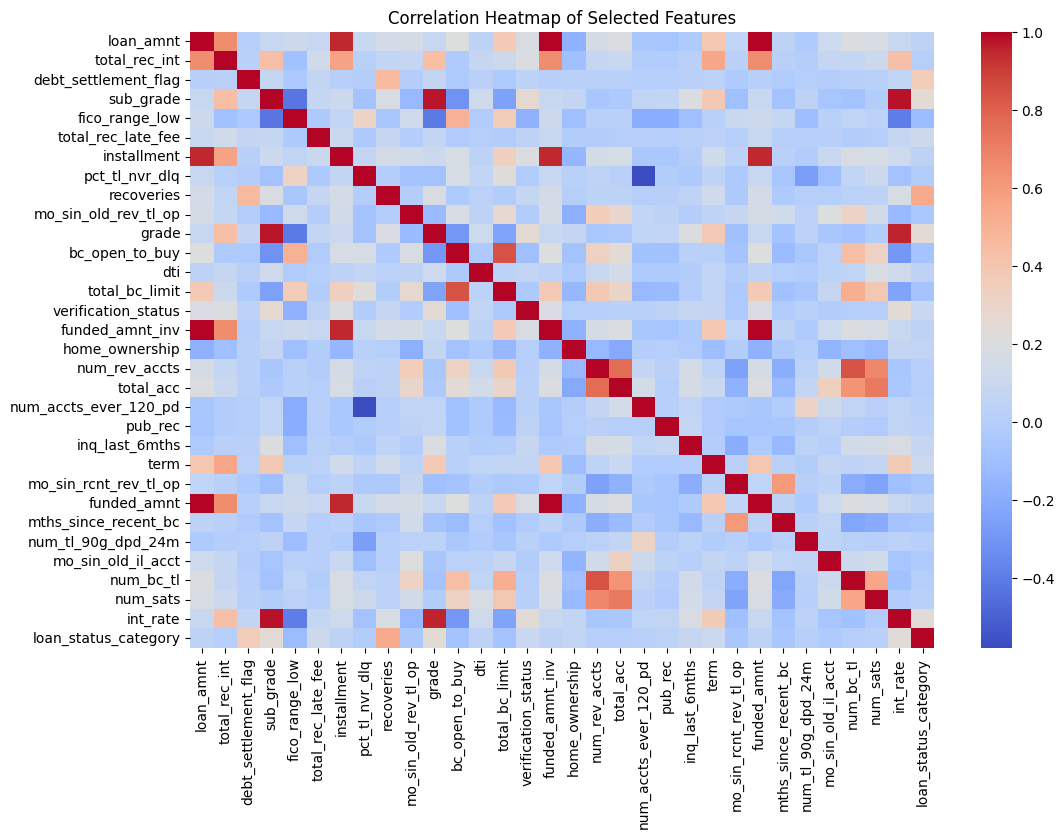

In [ ]:
# 6. Correlation analysis (Visualisation)

# Reduce dataset to selected features
X_selected = X[final_features]
df_selected = pd.concat([X_selected, y], axis=1)

# Compute and display the Correlation Matrix
corr_matrix = df_selected.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Selected Features")
plt.show()

In [ ]:
# Compute the correlation matrix for the selected features
corr_matrix = X_selected.corr()

# Correlation threshold between features
corr_thresh = 0.6

# Get pairs of highly correlated features
corr_pairs = np.where(np.abs(corr_matrix) > corr_thresh)

# Get the matching correlated columns in tuples
high_corr_pairs = [(corr_matrix.columns[x], corr_matrix.columns[y])\
                   for x, y in zip(*corr_pairs) if x != y and x < y]

# List of features to drop
drop_ft_list = []

# For each correlated tuple
for ft_1, ft_2 in high_corr_pairs:

    # Compute the correlation of both features with the
    # target variable loan_status_category.
    corr_ft1_tgt = abs(df_selected[ft_1]\
                       .corr(df_selected['loan_status_category']))
    corr_ft2_tgt = abs(df_selected[ft_2]\
                       .corr(df_selected['loan_status_category']))

    # Select the feature to drop based on which is least
    # correlated to the target variable.
    ft_to_drop = ft_2 if corr_ft1_tgt >= corr_ft2_tgt else ft_1
    drop_ft_list.append(ft_to_drop)

# Remove duplicates.
drop_ft_list = list(set(drop_ft_list))

# Drop redundant features.
final_features = [ft for ft in final_features if ft not in drop_ft_list]

# Add the interest rate feature as it should be significant
# in predicting whether a loan defaults or not.
final_features.append("int_rate")

# Print final selected features
print(f"Final selected features:\n{final_features}")

Final selected features:
['debt_settlement_flag', 'sub_grade', 'fico_range_low', 'total_rec_late_fee', 'installment', 'pct_tl_nvr_dlq', 'recoveries', 'mo_sin_old_rev_tl_op', 'bc_open_to_buy', 'dti', 'verification_status', 'home_ownership', 'num_accts_ever_120_pd', 'pub_rec', 'inq_last_6mths', 'term', 'mo_sin_rcnt_rev_tl_op', 'num_tl_90g_dpd_24m', 'mo_sin_old_il_acct', 'num_sats', 'int_rate']


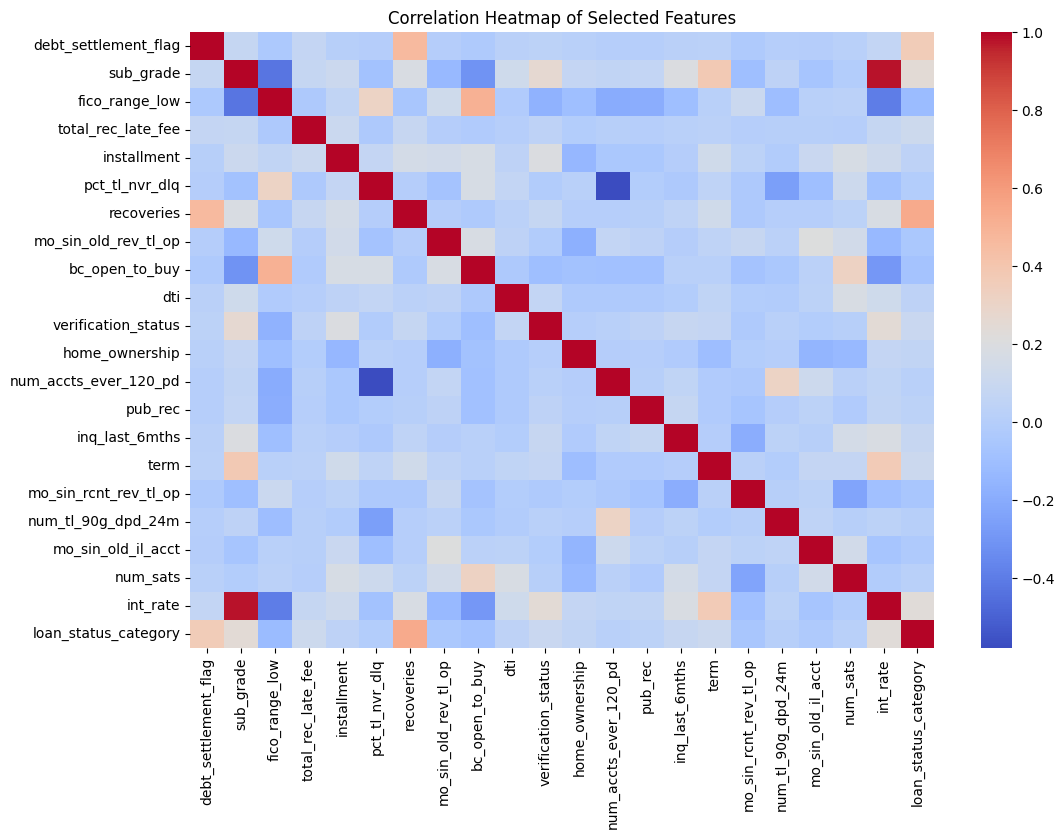

In [ ]:
# Reduce dataset to selected features
X_selected = X[final_features]
df_selected = pd.concat([X_selected, y], axis=1)

# Compute and display the Correlation Matrix
corr_matrix = df_selected.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Selected Features")
plt.show()

In [ ]:
# 7. Saving selected features to CSV.

# Save the cleaned dataset
df_selected.to_csv("loan_data_selected_features.csv", index=False)
print(f"Saved dataset with {df_selected.shape[1]-1} features.")
print(f"Dataframe shape: {df_selected.shape}")

# Download the new data source.
# from google.colab import files
# files.download("loan_data_selected_features.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Original class distribution: Counter({0: 1699237, 2: 314017, 1: 16698})
 New class distribution after SMOTE: Counter({0: 1359389, 2: 1359389, 1: 1359389})


<ipython-input-17-0b7c31730485>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette=["blue", "orange", "green"])


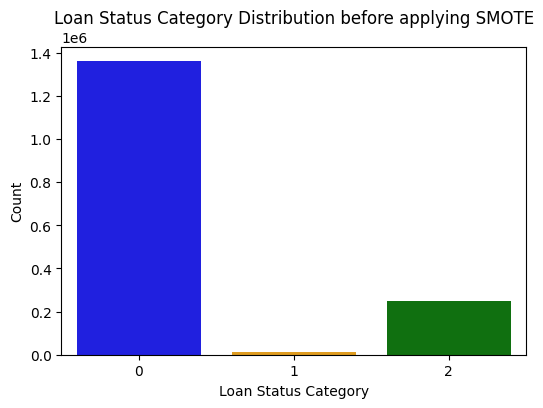

<ipython-input-17-0b7c31730485>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette=["blue", "orange", "green"])


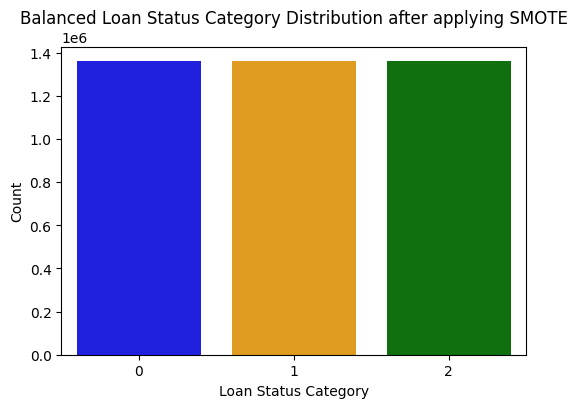

In [ ]:
# 8. Data balancing with SMOTE

# Check Original distribution
print("Original class distribution:",\
      Counter(df_selected["loan_status_category"]))

# Split into features and predictor.
X = df_selected.drop(columns=["loan_status_category"])
y = df_selected["loan_status_category"]

# The proportion of the testing set.
test_split = 0.2

# Split data to training and testing before applying SMOTE.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split,\
                                                    stratify=y, random_state=42)

# Apply SMOTE to training data.
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify new class distribution
print(" New class distribution after SMOTE:", Counter(y_train_resampled))

# visualize the training class distribution before resampling.
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train, palette=["blue", "orange", "green"])
plt.title("Loan Status Category Distribution before applying SMOTE")
plt.xlabel("Loan Status Category")
plt.ylabel("Count")
plt.show()

# visualize the training class distribution after resampling.
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_resampled, palette=["blue", "orange", "green"])
plt.title("Balanced Loan Status Category Distribution after applying SMOTE")
plt.xlabel("Loan Status Category")
plt.ylabel("Count")
plt.show()

In [ ]:
# Save the resampled data.

# Save balanced training data
df_train_balanced = pd.DataFrame(X_train_resampled, columns=X.columns)
df_train_balanced["loan_status_category"] = y_train_resampled
df_train_balanced.to_csv("loan_data_train_balanced.csv", index=False)
print(f"Saved balanced training dataset with {df_train_balanced.shape[0]} rows")

# Save original test set
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test["loan_status_category"] = y_test
df_test.to_csv("loan_data_test.csv", index=False)
print(f"Saved test dataset with {df_test.shape[0]} rows")

# Download the new data sources.
# from google.colab import files
# files.download("loan_data_train_balanced.csv")
# files.download("loan_data_test.csv")

Saved balanced training dataset with 4078167 rows
Saved test dataset with 405991 rows


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training data df shape:
 (4078167, 22)

Testing data df shape:
 (405991, 22)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:01:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Best hyperparameters found:
{'colsample_bytree': 0.6872700594236812, 'max_depth': 6, 'n_estimators': 370}
Best cross-validation ROC AUC: nan


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:01:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.06718
[1]	validation_0-mlogloss:1.03428
[2]	validation_0-mlogloss:1.00795
[3]	validation_0-mlogloss:0.98226
[4]	validation_0-mlogloss:0.95594
[5]	validation_0-mlogloss:0.93314
[6]	validation_0-mlogloss:0.91545
[7]	validation_0-mlogloss:0.89017
[8]	validation_0-mlogloss:0.86476
[9]	validation_0-mlogloss:0.84671
[10]	validation_0-mlogloss:0.82449
[11]	validation_0-mlogloss:0.80370
[12]	validation_0-mlogloss:0.78589
[13]	validation_0-mlogloss:0.77515
[14]	validation_0-mlogloss:0.76191
[15]	validation_0-mlogloss:0.74945
[16]	validation_0-mlogloss:0.73916
[17]	validation_0-mlogloss:0.72742
[18]	validation_0-mlogloss:0.71540
[19]	validation_0-mlogloss:0.70253
[20]	validation_0-mlogloss:0.68999
[21]	validation_0-mlogloss:0.67765
[22]	validation_0-mlogloss:0.66976
[23]	validation_0-mlogloss:0.65620
[24]	validation_0-mlogloss:0.65014
[25]	validation_0-mlogloss:0.64331
[26]	validation_0-mlogloss:0.63131
[27]	validation_0-mlogloss:0.62385
[28]	validation_0-mlogloss:0.6

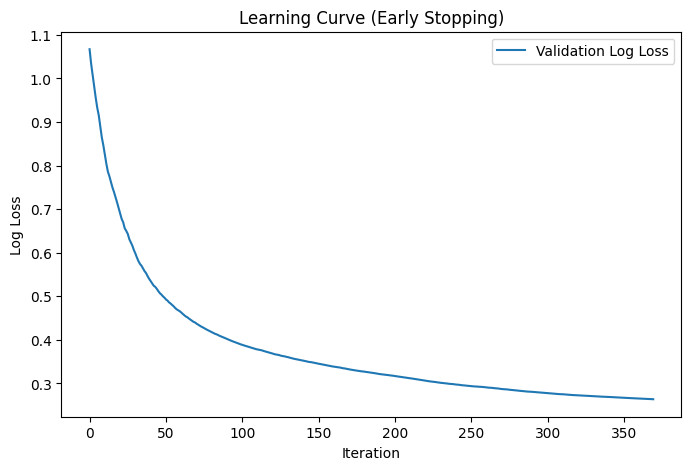


Evaluating final model on test data...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:02:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Test Accuracy: 0.9486
Test ROC AUC: 0.8895

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    339848
           1       0.12      0.04      0.06      3340
           2       1.00      0.73      0.85     62803

    accuracy                           0.95    405991
   macro avg       0.69      0.59      0.63    405991
weighted avg       0.95      0.95      0.94    405991

Confusion Matrix:
[[338951    879     18]
 [  3160    144     36]
 [ 16586    173  46044]]


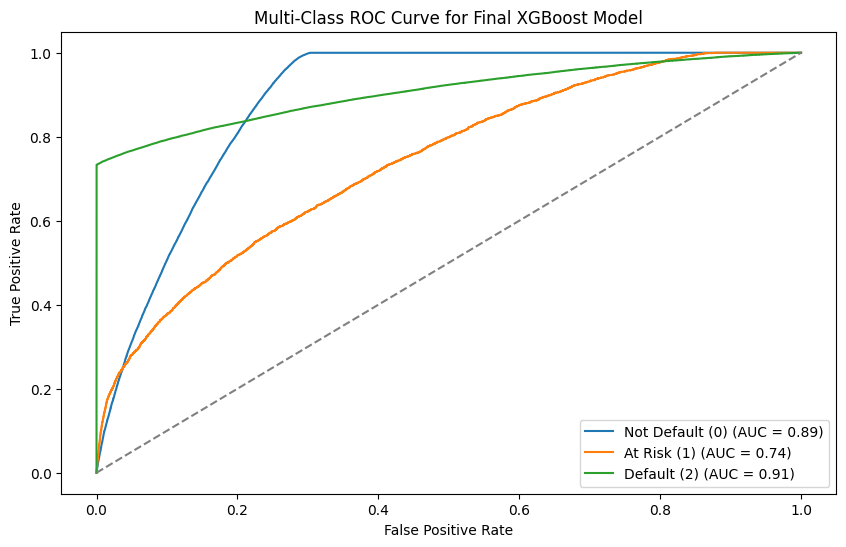

In [8]:
# 9. Model training and evaluation

# Load preprocessed training & testing data
df_train = pd.read_csv("loan_data_train_balanced.csv")  #  SMOTE applied
df_test = pd.read_csv("loan_data_test.csv")  # Original

# Log to user
print(f'Training data df shape:\n {df_train.shape}\n')
print(f'Testing data df shape:\n {df_test.shape}\n')

X_train = df_train.drop(columns=["loan_status_category"])
y_train = df_train["loan_status_category"]
X_test = df_test.drop(columns=["loan_status_category"])
y_test = df_test["loan_status_category"]

# Parameter tuning w cv
param_dist = {
    "max_depth": randint(2, 10),
    "n_estimators": randint(100, 1000),
    "colsample_bytree": uniform(0.5, 0.5)
}

# Define a base model without early stopping for CV tuning
base_model = XGBClassifier(
    booster="gbtree",
    learning_rate=0.05,
    subsample=0.8,
    tree_method="gpu_hist", # USE GPU
    device="cuda",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

# Use StratifiedKFold to preserve class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=10,  # Try n random combinations
    scoring="roc_auc",  # Use ROC AUC as scoring metric
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Run cross-validation tuning on the full training set
random_search.fit(X_train, y_train)

# Print best hyperparameters and best CV score
print("\nBest hyperparameters found:")
print(random_search.best_params_)
print(f"Best cross-validation ROC AUC: {random_search.best_score_:.4f}")

# Split the original training data to create a validation set for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

final_model = XGBClassifier(
    booster="gbtree",
    learning_rate=0.05,
    subsample=0.8,
    tree_method="gpu_hist", # USE GPU
    device="cuda",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
    max_depth=random_search.best_params_["max_depth"],
    n_estimators=random_search.best_params_["n_estimators"],
    colsample_bytree=random_search.best_params_["colsample_bytree"],
)

# Train final model with a validation set provided in eval_set
eval_set = [(X_val, y_val)]
final_model.fit(
    X_train_sub, y_train_sub,
    eval_set=eval_set,
    verbose=True
)

# Plot learning curves
evals_result = final_model.evals_result()
plt.figure(figsize=(8, 5))
plt.plot(evals_result["validation_0"]["mlogloss"], label="Validation Log Loss")
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.title("Learning Curve (Early Stopping)")
plt.legend()
plt.show()


print("\nEvaluating final model on test data...")

y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)



In [ ]:
# Compute evaluation metrics
accuracy = final_model.score(X_test, y_test)
auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC: {auc_score:.4f}")
print("\nClassification Report:")
print(report)
print("Confusion Matrix:")
print(cm)

# -----------------------------
# Multi-Class ROC Curve Plotting
# -----------------------------
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
plt.figure(figsize=(10, 6))

class_labels = ["Not Default (0)", "At Risk (1)", "Default (2)"]
for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve for Final XGBoost Model")
plt.legend()
plt.show()